<a href="https://colab.research.google.com/github/ShivinM-17/PyTorch-practices/blob/main/PyTorch_paper_replicating_Vit_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyTorch Paper Replicating

The goal of machine learning research paper replicating is: turn a ML research paper into usable code.

In this notebook, we will be replicating the Vision Transformer (ViT) architecture using PyTorch : `https://arxiv.org/pdf/2010.11929v2.pdf`



### Get setup

Importing code we've already written and the required libraries

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.0+cu121
torchvision version: 0.16.0+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Counting objects: 100% (4056/4056), done.
remote: Compressing objects: 100% (1626/1626), done.
remote: Total 4056 (delta 2387), reused 3946 (delta 2369), pack-reused 0
Receiving objects: 100% (4056/4056), 649.87 MiB | 28.25 MiB/s, done.
Resolving deltas: 100% (2387/2387), done.
Updating files: 100% (248/248), done.


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Since the goal is the replicate the ViT architecture for the FoodVision Mini problem.

To do that, we need some data, i.e., the pizza, steak, sushi data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directories to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Create Datasets and DataLoaders

In [7]:
from going_modular.going_modular import data_setup
from torchvision import transforms

# Create image size
IMG_SIZE = 224  # comes from table 3 from the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [8]:
# Here, the batch size will be taken as 32
# (in paper, it was 4096, but since we don't have much compute ability, we do 32)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### Visualize a single image

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

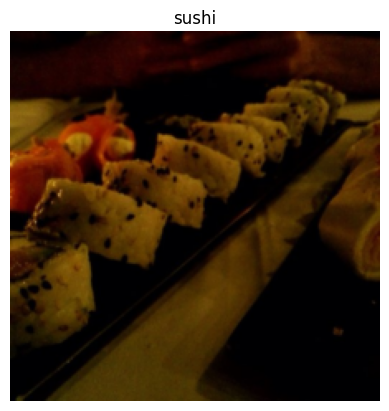

In [10]:
# Plot the image with matplotlib
import matplotlib.pyplot as plt
plt.imshow(image.permute(1, 2, 0)) # (Color_channels, heights, width) -> (height, width, color_channel)
plt.title(class_names[label])
plt.axis(False);

### Replicating ViT: Overview

Looking at a whole machine learning research paper can be imtimidating.

So in order to make it more understandable, we can break it down into smaller pieces:

* **Inputs** - What goes into the model? (in our case, image tensors)
* **Outputs** - What comes out of the model/layer/block? (in our case, we want the model to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention).
* **Blocks** - A collection of layers.
* **Model (or architecture)** - A collection of blocks.

#### ViT overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Four equations: math equations which define the functions of each layer/block
* Table 1/3: different hyperparameters for the architecture/training.
* Text descriptions (especially section 3.1)



##### Figure 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png" width=600 alt="figure 1 from vision transformer paper"/>

* Embedding = learnable representation (start with random numbers and improve over time)



##### Four equations

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=600 alt="four equations from vision transformer paper"/>

#### Section 3.1 describes the various equations:

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocode:

```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```



---

**Equations 2&3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudocode:

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```
---


**Equation 4:**
Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_{L}^{0}$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time

In pseudocode:

```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block))
```

##### Table 1

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png" width=600 alt="table 1 from vision transformer paper"/>

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture
* ViT-B/16 = ViT-Base with image patch size 16x16
* Layers - the number of transformer encoder layers
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size - the number of hidden units/neurons in the MLP
* Heads - the number of multi-head self-attention


### Equation 1: Split data into patches and creating the class, position and patch embedding

Layers = input -> function -> output

What's the input shape?

What's the output shape?

* Input shape: (224, 224, 3) -> single image -> (height, width, color_channels)

* Output shape

According to the section 3.1:
* Input shape: $H\times{W}\times{C}$ (height x width x color channels)
* Output shape: $(N \times\left(P^{2} \cdot C\right))$
* H: height
* W: width
* C: Color channels
* P: patch size
* N: number of patches = (height*width) / p^2
* D: constant latent vector size = embedding dimension

In [11]:
# Create some example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [12]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


#### Turning a single image into patches

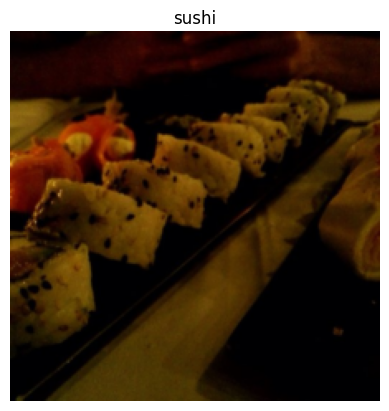

In [13]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [14]:
image.shape

torch.Size([3, 224, 224])

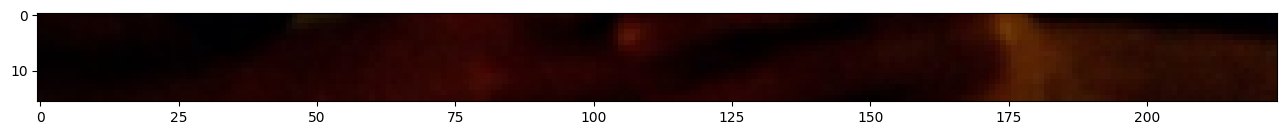

In [15]:
# Get the top row of the image
image_permuted = image.permute(1, 2, 0)  # convert image to color channels last (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size,:,:]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


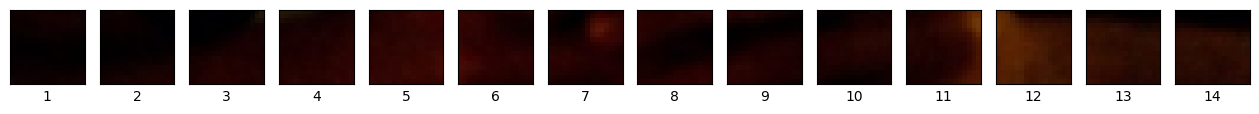

In [16]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size==0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axes = plt.subplots(nrows = 1,
                         ncols = img_size // patch_size, # one column per patch
                         sharex = True,
                         sharey = True,
                         figsize = (patch_size, patch_size)
                         )

# Iterate through number of patches in top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axes[i].imshow(image_permuted[:patch_size, patch: patch + patch_size, :])
  axes[i].set_xlabel(i+1)
  axes[i].set_xticks([])
  axes[i].set_yticks([])

Number of patches per row: 14.0
Number of patches per column: 14.0
Total patches: 196.0
Patch size: 16 pixels x 16 pixels


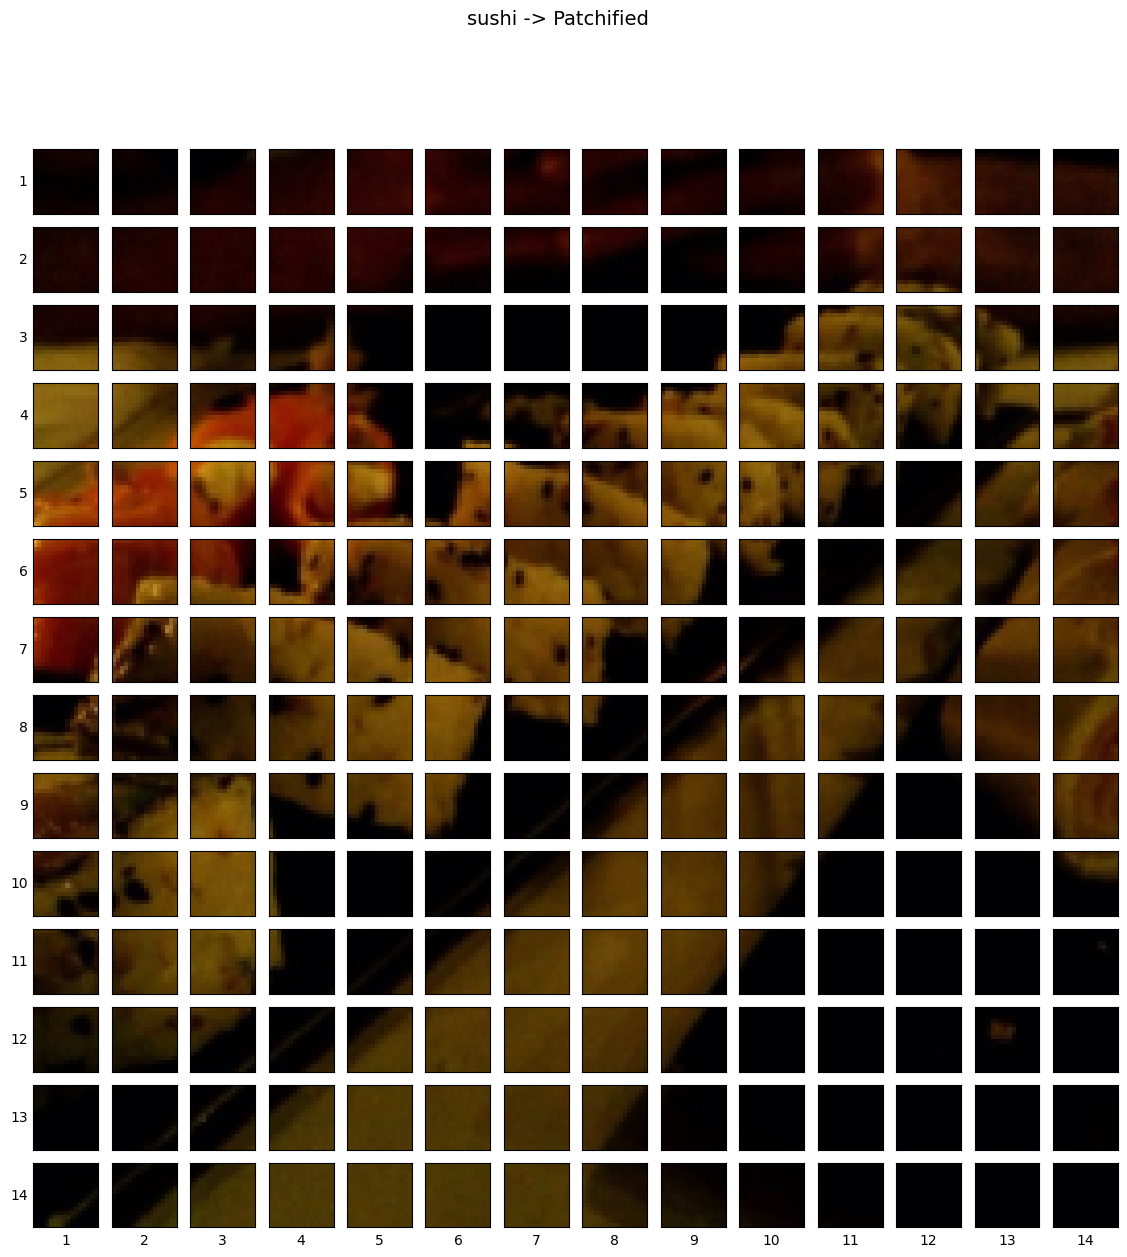

In [17]:
# Setup code to plot whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
\nNumber of patches per column: {num_patches}\
\nTotal patches: {num_patches * num_patches}\
\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axes = plt.subplots(nrows = img_size // patch_size,
                         ncols = img_size // patch_size,
                         figsize = (num_patches, num_patches),
                         sharex = True,
                         sharey = True)

# Loop through height and width of the image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    # Plot the permutted image on the different axes
    axes[i, j].imshow(image_permuted[patch_height: patch_height + patch_size,
                                     patch_width: patch_width + patch_size,
                                     :])
    # Setup label information for each subplot (patch)
    axes[i, j].set_ylabel(i+1,
                          rotation = "horizontal",
                          horizontalalignment = "right",
                          verticalalignment = "center")
    axes[i, j].set_xlabel(j+1)
    axes[i, j].set_xticks([])
    axes[i, j].set_yticks([])
    axes[i, j].label_outer()

# Setup a title for the plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize = 14)
plt.show()

#### Creating image patches and turning them into patch embeddings


We create the image patches and image patch embeddings in a single step using `torch.nn.Conv2d()` and setting the kernel size and stride parameters to `patch_size`

In [18]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(
    in_channels = 3, # for color images
    out_channels = 768, # D size from Table 1
    kernel_size = patch_size,
    stride = patch_size,
    padding = 0
)

conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

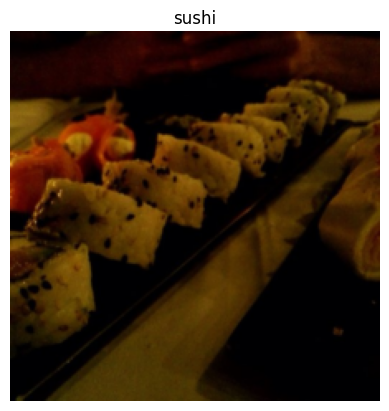

In [19]:
# View single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [20]:
# Pass the image through the convolutional 2D layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, color_channels, height, width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we've passed a single image to the `conv2d` layer, we get the shape as:

```python
torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

In [21]:
image_out_of_conv

tensor([[[[ 0.0042,  0.0102, -0.0004,  ...,  0.0538,  0.0602,  0.0544],
          [ 0.0285,  0.0250,  0.0304,  ...,  0.0439,  0.0573,  0.0278],
          [-0.0003, -0.0468, -0.0279,  ...,  0.0849,  0.0021, -0.0039],
          ...,
          [ 0.0113,  0.0505,  0.0468,  ..., -0.0032,  0.0245, -0.0031],
          [-0.0025, -0.0046,  0.0600,  ..., -0.0031, -0.0031, -0.0006],
          [-0.0030,  0.0487,  0.0262,  ..., -0.0036, -0.0031, -0.0035]],

         [[ 0.0026,  0.0154,  0.0048,  ...,  0.0104,  0.0173,  0.0045],
          [-0.0092, -0.0124, -0.0212,  ..., -0.0367, -0.0318, -0.0142],
          [ 0.0945,  0.0915,  0.0105,  ..., -0.0133, -0.0081,  0.0657],
          ...,
          [-0.0035, -0.0340, -0.0010,  ...,  0.0063,  0.0143,  0.0064],
          [ 0.0085,  0.0121,  0.0090,  ...,  0.0064,  0.0064,  0.0051],
          [ 0.0211, -0.0172, -0.0269,  ...,  0.0062,  0.0064,  0.0056]],

         [[ 0.0192, -0.0010,  0.0020,  ...,  0.0226,  0.0156, -0.0065],
          [ 0.0157,  0.0155,  

Showing random convolutional feature maps from indexes: [476, 96, 621, 224, 636]


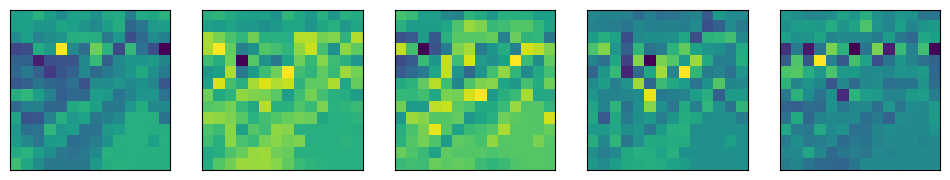

In [22]:
# Plot random convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k = 5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the conv2d layer
  axes[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimenstion, and remove from grad tracking/switch to numpy for matplotlib
  axes[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [23]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 4.1891e-03,  1.0194e-02, -4.1333e-04,  2.7575e-02,  3.7702e-02,
            3.0599e-02,  1.4807e-02,  2.2544e-02, -4.6615e-03,  2.4540e-02,
            3.2522e-02,  5.3843e-02,  6.0229e-02,  5.4415e-02],
          [ 2.8500e-02,  2.5024e-02,  3.0353e-02,  3.4061e-02,  2.8059e-02,
            3.4885e-02,  3.8450e-02,  2.5138e-02, -4.8326e-03,  2.1518e-02,
            7.0509e-02,  4.3859e-02,  5.7349e-02,  2.7827e-02],
          [-3.1679e-04, -4.6773e-02, -2.7924e-02,  5.2758e-02, -3.6300e-02,
           -4.1175e-03, -2.9420e-03, -2.6218e-03,  1.8455e-02,  5.7784e-02,
            1.4459e-01,  8.4872e-02,  2.0837e-03, -3.8807e-03],
          [ 9.7542e-02,  9.4354e-02,  4.1461e-02,  1.8824e-01,  4.4634e-02,
            2.7779e-02,  8.8991e-02,  6.2939e-02,  4.4487e-02,  1.2576e-01,
            1.0497e-02,  5.3875e-02,  9.1173e-02,  8.8783e-02],
          [ 7.0132e-02,  9.1246e-02,  8.4527e-02,  8.1534e-02,  1.3806e-01,
            2.1290e-02,  4.9094e-02,  5.3544e-02,  6.5648e-0

#### Flattening the patch embedding with `torch.nn.Flatten()`

Right now, we have a series of convolutional feature maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfy the input criteria of the ViT Transformer Encoder.



In [24]:
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


What we require is the shape as: `[1, 768, 196]` or `[batch_size, number_of_patches, embedding_dim]`

In [25]:
from torch import nn
flatten_layer = nn.Flatten(start_dim = 2,
                           end_dim = 3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flatten image feature map shape: torch.Size([1, 768, 196])


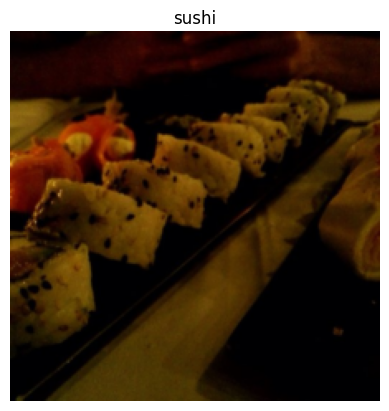

In [26]:
# Put everything together
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flatten image feature map shape: {image_out_of_conv_flattened.shape}")

In [27]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
print(f"{image_out_of_conv_flattened.permute(0, 2, 1).shape} -> num_of_batches, patch_size, embedding_dim")

torch.Size([1, 196, 768]) -> num_of_batches, patch_size, embedding_dim


In [28]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]
single_flattened_feature_map

tensor([[ 4.1891e-03,  1.0194e-02, -4.1333e-04,  2.7575e-02,  3.7702e-02,
          3.0599e-02,  1.4807e-02,  2.2544e-02, -4.6615e-03,  2.4540e-02,
          3.2522e-02,  5.3843e-02,  6.0229e-02,  5.4415e-02,  2.8500e-02,
          2.5024e-02,  3.0353e-02,  3.4061e-02,  2.8059e-02,  3.4885e-02,
          3.8450e-02,  2.5138e-02, -4.8326e-03,  2.1518e-02,  7.0509e-02,
          4.3859e-02,  5.7349e-02,  2.7827e-02, -3.1679e-04, -4.6773e-02,
         -2.7924e-02,  5.2758e-02, -3.6300e-02, -4.1175e-03, -2.9420e-03,
         -2.6218e-03,  1.8455e-02,  5.7784e-02,  1.4459e-01,  8.4872e-02,
          2.0837e-03, -3.8807e-03,  9.7542e-02,  9.4354e-02,  4.1461e-02,
          1.8824e-01,  4.4634e-02,  2.7779e-02,  8.8991e-02,  6.2939e-02,
          4.4487e-02,  1.2576e-01,  1.0497e-02,  5.3875e-02,  9.1173e-02,
          8.8783e-02,  7.0132e-02,  9.1246e-02,  8.4527e-02,  8.1534e-02,
          1.3806e-01,  2.1290e-02,  4.9094e-02,  5.3544e-02,  6.5648e-02,
          6.2664e-03,  5.5025e-02,  1.

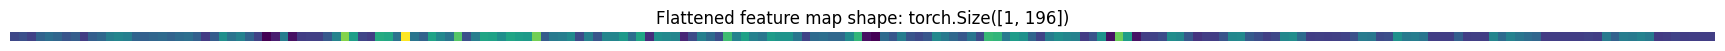

In [29]:
# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

#### Turning the ViT patch embedding layer into a PyTorch module

We want this module to do a few things:
1. Create a class called `PatchEmbedding` inherits from `nn.Module`
2. Initialize with appropriate hyperparameters, such as channels, embedding dimension, patch size.
3. Create a layer to turn an image into embedding patches using `nn.Conv2d()`
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` that defines the forward computation (e.g. pass through layer from 3 and 4)
6. Make sure the output shape of the layer reflects the required output shape of the patch embedding.

In [30]:
# 1. Create a class called PatchEmbedding
class PatchEmbedding(nn.Module):
  # 2. Initialize the layer with appropiate hyperparameters
  def __init__(self,
               in_channels:int = 3,
               patch_size: int = 16,
               embedding_dim: int = 768): # from Table 1 for ViT-Base
     super().__init__()

     self.patch_size = patch_size

     # 3. Create a layer to turn an image into embedded patches
     self.patcher = nn.Conv2d(
         in_channels = in_channels,
         out_channels = embedding_dim,
         kernel_size = patch_size,
         stride = patch_size,
         padding = 0
     )

     # 4. Create a layer to flatten feature map outputs of Conv2d
     self.flatten = nn.Flatten(start_dim = 2,
                               end_dim = 3)

  # 5. Define a forward method to define the forward computation steps
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch_size: {self.patch_size}"

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # Make sure the returned sequence embedding dimensions are in the right order (batch_size, number_of_patches, embedding_dimensions)
    return x_flattened.permute(0, 2 , 1)

In [31]:
set_seeds(42)

# Create an instance of the patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [32]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

# patchify(rand_image_tensor_bad)

#### Creating the class token embedding

Here, we want to prepend a learnable class token to the start of the patch embedding.


In [33]:
patch_embedded_image

tensor([[[-0.0335, -0.0277, -0.0308,  ...,  0.0243, -0.0149,  0.0113],
         [-0.0506, -0.0304, -0.0244,  ...,  0.0304, -0.0233,  0.0235],
         [-0.0827, -0.0292, -0.0057,  ...,  0.0226, -0.0437,  0.0331],
         ...,
         [-0.0202, -0.0105, -0.0329,  ...,  0.0129, -0.0029,  0.0035],
         [-0.0200, -0.0107, -0.0316,  ...,  0.0123, -0.0033,  0.0033],
         [-0.0204, -0.0124, -0.0321,  ...,  0.0134, -0.0030,  0.0025]]],
       grad_fn=<PermuteBackward0>)

In [34]:
# Get the batch size and embedding dimenstion
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [35]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad = True)
class_token

Parameter containing:
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 

In [36]:
class_token.shape

torch.Size([1, 1, 768])

In [37]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [38]:
# Add the class token embedding to the front of patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim = 1) # number_of_patches dimension
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape}\n   -> (batch_size, class_token + number_of_patches, embedding_dimensions)")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0335, -0.0277, -0.0308,  ...,  0.0243, -0.0149,  0.0113],
         [-0.0506, -0.0304, -0.0244,  ...,  0.0304, -0.0233,  0.0235],
         ...,
         [-0.0202, -0.0105, -0.0329,  ...,  0.0129, -0.0029,  0.0035],
         [-0.0200, -0.0107, -0.0316,  ...,  0.0123, -0.0033,  0.0033],
         [-0.0204, -0.0124, -0.0321,  ...,  0.0134, -0.0030,  0.0025]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768])
   -> (batch_size, class_token + number_of_patches, embedding_dimensions)


#### Creating the position embedding

Here, we want ot create a series of 1D learnable position embeddings to add them to the sequence of the patch embeddings

In [39]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0335, -0.0277, -0.0308,  ...,  0.0243, -0.0149,  0.0113],
          [-0.0506, -0.0304, -0.0244,  ...,  0.0304, -0.0233,  0.0235],
          ...,
          [-0.0202, -0.0105, -0.0329,  ...,  0.0129, -0.0029,  0.0035],
          [-0.0200, -0.0107, -0.0316,  ...,  0.0123, -0.0033,  0.0033],
          [-0.0204, -0.0124, -0.0321,  ...,  0.0134, -0.0030,  0.0025]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [40]:
# Calculate N (number of patches)
number_of_patches = int(int(height * width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

# Create learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches + 1,
                                             embedding_dimension),
                                  requires_grad = True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [41]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9665, 0.9723, 0.9692,  ..., 1.0243, 0.9851, 1.0113],
         [0.9494, 0.9696, 0.9756,  ..., 1.0304, 0.9767, 1.0235],
         ...,
         [0.9798, 0.9895, 0.9671,  ..., 1.0129, 0.9971, 1.0035],
         [0.9800, 0.9893, 0.9684,  ..., 1.0123, 0.9967, 1.0033],
         [0.9796, 0.9876, 0.9679,  ..., 1.0134, 0.9970, 1.0025]]],
       grad_fn=<AddBackward0>)
Patch and position embedding shape: torch.Size([1, 197, 768])


#### Putting it all together: from image to embedding

Now that we have written the code to turn an image in a flattened sequence of patch embeddings. Now, we make all of it as one.


In [42]:
# Set the seeds
set_seeds(42)

# 1. Set the patch size
patch_size = 16

# 2. Print shapes of the original image tensor and get the image dimension
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels = 3,
                                       patch_size = patch_size,
                                       embedding_dim = 768)

# 5. Pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad = True) # Make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height*width)/ patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad = True)

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


### Equation 2: Multihead self-attention (MSA block)

* Multihead self-attention: which part of the sequence should pay the most attention to itself?
 * In our case, we have a series of embedded image patches, which patch significantly related to another patch
 * We want our neural networks (ViT) to learn this relationship / representation
* To replicate MSA in PyTorch, we can use: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html
* LayerNorm: Layer normalization (LayerNorm) is a technique to normalize the distribution of intermediate learning gradients, faster training and better generalization accuracy.
 * Normalization = make everything have the same mean and same standard deviation
 * In PyTorch: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html, normalizes values over $D$ dimension, in our case, the $D$ dimension is the embedding dimension.
   * When we normalize along the embedding dimension, it's like making all of the stairs in equal sizes.

In [43]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """
  Creates a multi-head self-attention block ("MSA Block" for short)
  """
  def __init__(self,
               embedding_dim:int = 768, # Hidden size D from Table 1 for ViT base model
               num_heads:int = 12, # Heads from Table 1 for ViT-Base
               attn_dropout:int = 0
               ):
    super().__init__()

    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

    # Create multihead attention (MSA) layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                num_heads = num_heads,
                                                dropout = attn_dropout,
                                                batch_first = True) # if true, then input, output is taken as (batch, seq, feature) -> (batch, number_of_patches, embedding_dimension)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query = x,
                                         key = x,
                                         value = x,
                                         need_weights = False)
    return attn_output

In [44]:
# Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(
    embedding_dim = 768,
    num_heads = 12,
    attn_dropout = 0
)

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [45]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9665, 0.9723, 0.9692,  ..., 1.0243, 0.9851, 1.0113],
         [0.9494, 0.9696, 0.9756,  ..., 1.0304, 0.9767, 1.0235],
         ...,
         [0.9798, 0.9895, 0.9671,  ..., 1.0129, 0.9971, 1.0035],
         [0.9800, 0.9893, 0.9684,  ..., 1.0123, 0.9967, 1.0033],
         [0.9796, 0.9876, 0.9679,  ..., 1.0134, 0.9970, 1.0025]]],
       grad_fn=<AddBackward0>)

In [46]:
patched_image_through_msa_block

tensor([[[-2.7822e-02, -3.3607e-04,  2.4068e-02,  ..., -2.6934e-01,
           6.9232e-01, -3.1934e-01],
         [-2.7273e-02, -4.8255e-02,  4.8257e-02,  ..., -2.2168e-01,
           6.9353e-01, -3.2697e-01],
         [-4.8151e-02, -4.9198e-02,  6.9151e-02,  ..., -2.3891e-01,
           7.1388e-01, -3.0565e-01],
         ...,
         [-5.0962e-02, -4.1884e-02,  1.9834e-02,  ..., -1.9832e-01,
           6.8525e-01, -3.3333e-01],
         [-5.1825e-02, -4.2425e-02,  1.9847e-02,  ..., -1.9966e-01,
           6.8567e-01, -3.3300e-01],
         [-5.0443e-02, -4.3241e-02,  1.7019e-02,  ..., -1.9924e-01,
           6.8563e-01, -3.3492e-01]]], grad_fn=<TransposeBackward0>)

### Equation 3: Multilayer Perceptron (MLP Block)

* **MLP**: The MLP contains two layers with a GELU non-linearity (section 3.1)
 * MLP: a quite broad term for a block with a series sof layer(s), layers can be multiple or even only one hidden layer.
 * Layers can mean: fully-connected, dense, linear, feed-forward, all are often similar names for the same thing. In PyTorch, they're often called `torch.nn.Linear()` and in Tensorflow they might be called `tf.keras.Dense()`
 * GELU in PyTorch
 * MLP number of hidden units is the MLP size in the table 1
* **Dropout**: applied after every dense layer in the MLP
 * Value for dropout available in Table 3 of the paper

In pseudocode:
```python
# MLP
x = linear -> non-linear -> dropout -> linear -> dropout

```

In [47]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim: int = 768,
               mlp_size: int = 3072,
               dropout: float = 0.1):
    super().__init__()

    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dim,
                  out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features = mlp_size,
                  out_features = embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x
    # return self.mlp(self.layer_norm(x)) -> same as above

In [48]:
# Create an instance of the MLP Block
mlp_block = MLPBlock(embedding_dim = 768,
                     mlp_size = 3072,
                     dropout = 0.1)

# Pass the output of the MSABlock through the MLPBlock
patch_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MSA block: {patch_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


### Creating the Transformer Encoder

The transformer encoder is a series of alternating blocks of MSA (equation 2) and MLP (equation 3).

* Encoder: turn a sequence into learnable representation
* Decoder: go from learn representation back to some sort of sequence
* Residual connections: add a layer(s) input to its subsequent output, this enables the creation of deeper networks (prevents weights from getting too small)

In pseudocode:

```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```


#### Create a transformer encoder class

In [49]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768, # hidden size D from table 1
               num_heads:int = 12,  # count of multi-attention heads
               mlp_size: int = 3072,  # from table 1
               mlp_dropout:float = 0.1, # from table 3
               attn_dropout:int = 0):
    super().__init__()

    # Create MSA block (equation 2)
    self.msa_block = MultiHeadSelfAttentionBlock(
        embedding_dim = embedding_dim,
        num_heads = num_heads,
        attn_dropout = attn_dropout
    )

    # Create MLP Block (equation 3)
    self.mlp_block = MLPBlock(embedding_dim = embedding_dim,
                              mlp_size = mlp_size,
                              dropout = mlp_dropout)
  def forward(self, x):
    x = self.msa_block(x) + x # residual/skip connection for equation 2
    x = self.mlp_block(x) + x # residual/skip connection for equation 3
    return x

In [50]:
# Create an instance of the TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model = transformer_encoder_block,
        input_size = (1, 197, 768),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width =  20,
        row_settings = ["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

#### Create a PyTorch Encoder layer with in-built PyTorch layers

But because of how good the Transformer architecture is, PyTorch has implemented ready to use Transformer Encoder layers.

There is another transformers that can be used as an substitute for this: `BetterTransformer` whose improvements can exceed 2x in speedup and throughput for many common execution scenarios.

In [51]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model = 768,  # embedding size from table 1
    nhead = 12,  # heads from table 1
    dim_feedforward = 3072,  # MLP size from table
    dropout = 0.1,
    activation = "gelu",
    batch_first = True,
    norm_first = True
)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [52]:
# Get a summary using torchinfo.summary
summary(model = torch_transformer_encoder_layer,
        input_size = (1, 197, 768),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width =  20,
        row_settings = ["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

### Putting it all together to create ViT

In [53]:
# Create a ViT class
class ViT(nn.Module):
  def __init__(self,
               img_size: int = 224,  # Table 3 from the ViT paper
               in_channels:int = 3,
               patch_size: int = 16,
               num_transformer_layers: int = 12, # Table 1 for  'Layers' for ViT-Base
               embedding_dim: int = 768, # hidden size D from Table 1 for ViT-Base
               mlp_size: int = 3072,   # Table 1
               num_heads: int = 12,   # Table 1
               attn_dropout: int = 0,
               mlp_dropout:int = 0.1,
               embedding_dropout:int = 0.1, # Dropout for patch and position embeddings
               num_classes: int = 1000 # number of classes in the classification problem
               ):
    super().__init__()

    # Make an assertion that the image size is compatible with the patch size
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}"

    # Calculate the number of patches (height * width / patch **2)
    self.num_patches = (img_size * img_size) // patch_size**2

    # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data = torch.randn(1, 1, embedding_dim),
                                        requires_grad = True)

    # Create learnable position embedding
    self.position_embedding = nn.Parameter(data = torch.randn(1, self.num_patches+1, embedding_dim))

    # Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels = in_channels,
                                           patch_size = patch_size,
                                           embedding_dim = embedding_dim)

    # Create the Transformer Encoder Block
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(
        embedding_dim = embedding_dim,
        num_heads = num_heads,
        mlp_size = mlp_size,
        mlp_dropout = mlp_dropout
        ) for _ in range(num_transformer_layers)])

    # Create classifier jead
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape = embedding_dim),
        nn.Linear(in_features = embedding_dim,
                  out_features = num_classes)
    )

  # Create the forward method
  def forward(self, x):
    # Get the batch size
    batch_size = x.shape[0]

    # Create class token embedding and expand it to match the batch size (eq.1)
    class_token = self.class_embedding.expand(batch_size, -1, -1)  # "-1" means to infer the dimensions

    # Create the patch embedding (eq.1)
    x = self.patch_embedding(x)

    # Concat class token embedding and patch embedding (eq.1)
    x = torch.cat((class_token, x), dim = 1) # (batch_size, number_of_patches, embedding_dim)

    # Add position embedding to class token and patch embedding
    x = self.position_embedding + x

    # Apply dropout to patch_embedding (directly after adding position to patch embedding)
    x = self.embedding_dropout(x)

    # Pass position and patch embedding to Transformer Encoder (eq. 2 and 3)
    x = self.transformer_encoder(x)

    # Put 0th index logit through classifier (eq. 4)
    x = self.classifier(x[:, 0])
    return x


In [54]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

In [55]:
set_seeds()

# Create a random image tensor with the same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working with (pizza, steak and sushi)
vit = ViT(num_classes = len(class_names))

# Pass the random image tensor to the ViT tensor
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

#### Getting a visual summary of the ViT model

In [56]:
from torchinfo import summary

summary(model= ViT(num_classes = len(class_names)),
        input_size = (1, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

### Setting up training code for the custom ViT

We have replicated the ViT architecture, now we can see how it performs on our FoodVision Mini data

#### Create an optimizer

This papers uses the Adam optimizer (section 4), with $B1$ value of 0.9, $B2$ value of 0.999 (defaults) and a weight decay of 0.1.

Weight decay = weight decay is a regularization technizue by adding a small penalty, usually the L2 norm of the weights (all the weights of the model), to the loss function.

Regularization technique -> prevents overfitting.

In [57]:
optimizer = torch.optim.Adam(vit.parameters(),
                             lr=0.001,
                             betas = (0.9, 0.999),
                             weight_decay = 0.1)

#### Create a loss function

In [58]:
loss_fn = torch.nn.CrossEntropyLoss()

#### Training the ViT model

In [59]:
from going_modular.going_modular import engine

set_seeds()

results = engine.train(
    model = vit,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    epochs = 10,
    optimizer = optimizer,
    loss_fn = loss_fn,
    device = device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.8769 | train_acc: 0.3008 | test_loss: 1.0393 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.5149 | train_acc: 0.3047 | test_loss: 1.5085 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.4133 | train_acc: 0.2617 | test_loss: 1.4602 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.2590 | train_acc: 0.4102 | test_loss: 1.9581 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3003 | train_acc: 0.2812 | test_loss: 1.6453 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2523 | train_acc: 0.2969 | test_loss: 1.7504 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1795 | train_acc: 0.4102 | test_loss: 3.2498 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.4590 | train_acc: 0.2852 | test_loss: 1.3791 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.3394 | train_acc: 0.3672 | test_loss: 1.2890 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.4096 | train_acc: 0.3164 | test_loss: 1.3272 | test_acc: 0.2604


#### What our training setup is missing

How is our training setup different to the ViT paper?

The original ViT paper using far more amount of image data than we do and a longer training schedule.

The main things our training implementation is missing:

Prevent underfitting:
* Data - our setup uses far less data (225 vs millions)

Prevent overfitting:
* Learning rate warmup - start with a low learning rate and increase to a base LR
* Learning rate decay - as your model gets closer to convergence, start to lower the learning rate
* Gradient clipping - prevent gradients from getting too big

#### Plotting loss curves for our model

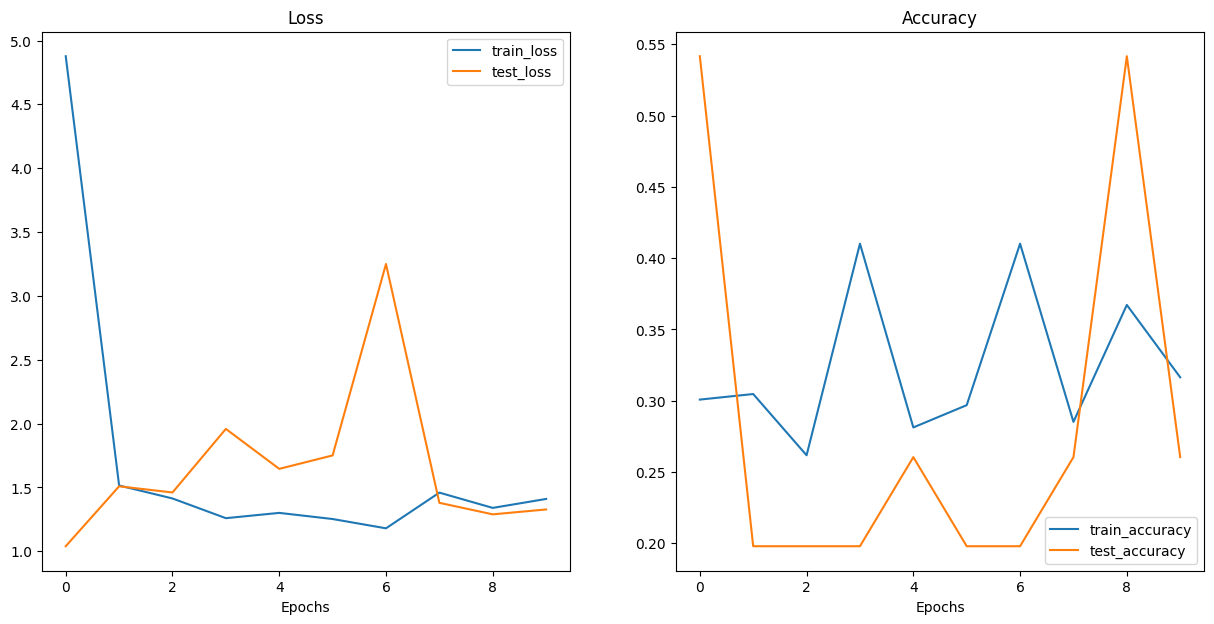

In [60]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

### Using a pretrained ViT from `torchvision.models`

Generally, in deep learning if you can use a pretrained model from a large dataset on your own problem, it's often a good place to start.

If you can find a pretrained model and use transfer learning, give it a go, since it achieves great results with little data.

**Why use a pretrained model?**
* Sometimes data is limited
* Limited training resources
* Get better results faster (sometimes)



In [61]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu121
0.16.0+cu121


In [62]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [63]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights = pretrained_vit_weights)

pretrained_vit

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 58.1MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [64]:
# Freeze the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

In [66]:
# Update the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names))

In [67]:
from torchinfo import summary

summary(model= pretrained_vit,
        input_size = (1, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

#### Preparing data for the pretrained ViT model

In [68]:
# Get the automatic transforms from pretrained vit model
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [70]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir  =test_dir,
    transform = vit_transforms,
    batch_size = 32
)

#### Train feature extractor ViT model

In [72]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params= pretrained_vit.parameters(),
                             lr = 1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Traing the classifier head of pretrained ViT
set_seeds()
pretrained_vit_results = engine.train(
    model = pretrained_vit,
    train_dataloader = train_dataloader_pretrained,
    test_dataloader = test_dataloader_pretrained,
    optimizer = optimizer,
    loss_fn = loss_fn,
    epochs = 10,
    device = device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


#### Plot the loss curves of the pretrained vit feature extractor model

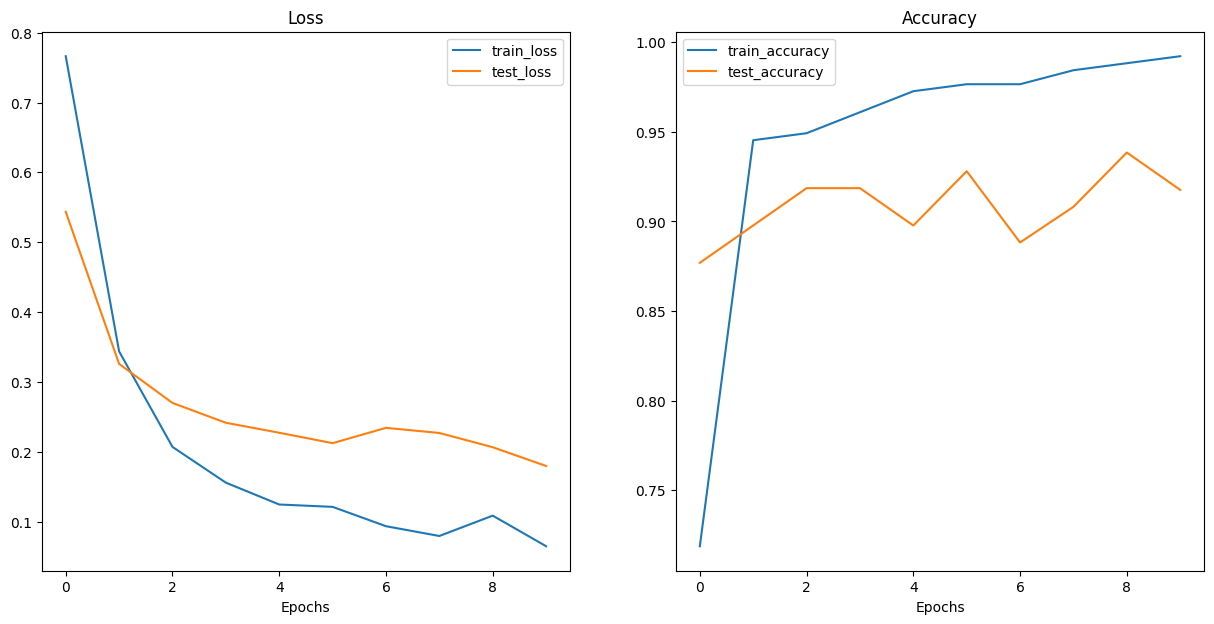

In [73]:
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_results)

#### Save the best performing vit model

Now that our model performs well, we want to save it to a file and check it's filesize.

We want to check the filesize because if we wanted to deploy a model to a website / mobile application, we may have limitations on the size of the model we can deploy.

E.g. a smaller model may be required due to compute restrictions

In [74]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model = pretrained_vit,
                 target_dir = "models",
                 model_name = "08_pretrained_vit_feature_extractor_model.pt")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_model.pt


In [76]:
from pathlib import Path

# Get the model size in bytes, then convert it to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_model.pt").stat().st_size // (1024 ** 2)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


Our pretrained ViT gets some of the best results we've seen so far on our FoodVision Mini problem, however, the model size is ~11x larger than our next best performing model.

Perhaps the larger model size might cause issues when we go to deploy it (e.g. hard to deploy such a large file/might not make predictions as fast as smaller models)

### Predicting on custom image

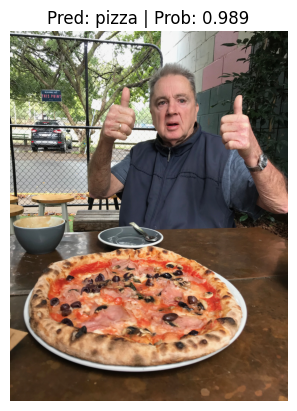

In [77]:
import requests

# Import the function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exists
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need to use the 'raw' file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(
    model = pretrained_vit,
    image_path = custom_image_path,
    class_names = class_names
)